In [347]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#nlp
import nltk
from nltk.tokenize import word_tokenize, RegexpTokenizer, WhitespaceTokenizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction import text
import re

import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora

In [305]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rachelinsler/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [268]:
filename = '2021_01.csv'
output_filename = 'cleaned.csv'
nlp_filename = 'nlp.csv'

In [269]:
df = pd.read_csv(filename, sep='\t')

In [270]:
df.head()

,date,title,subtitle,claps,responses,author_url,story_url,reading_time (mins),number_sections,section_titles,number_paragraphs,paragraphs
0,01/01/2021,7 Most Recommended Skills to Learn in 2021 to ...,Recommended by some of the largest…,1K,10,https://towardsdatascience.com/@terenceshin,https://towardsdatascience.com/7-most-recommen...,6,11,['7 Most Recommended Skills to Learn in 2021 t...,36,"['Terence Shin', 'Jan 1·6 min read', 'Happy Ne..."
1,01/01/2021,The Ultimate Guide to Acing Coding Interviews ...,Data Science Interview,489,4,https://towardsdatascience.com/@emmading,https://towardsdatascience.com/the-ultimate-gu...,11,12,['The Ultimate Guide to Acing Coding Interview...,42,"['Emma Ding', 'Jan 1·11 min read', 'Written by..."
2,01/01/2021,Shakespeare versus Eminem— who’s the better ly...,"He is known for his poetry, his writings on life…",139,2,https://towardsdatascience.com/@jeroenvanzeeland,https://towardsdatascience.com/shakespeare-ver...,9,13,['Shakespeare versus Eminem—who’s the better l...,64,"['Jeroen van Zeeland', 'Jan 1·9 min read', 'Da..."
3,01/01/2021,Customer Segmentation in Online Retail,A detailed step-by-step explanation on perform...,159,1,https://towardsdatascience.com/@rahulkhandelwal,https://towardsdatascience.com/customer-segmen...,19,15,"['Customer Segmentation in Online Retail', 'Un...",93,"['Rahul Khandelwal', 'Jan 1·19 min read', 'In ..."
4,01/01/2021,Implementing VisualTtransformer in PyTorch,"Hi guys, happy new year! Today we are going to...",133,2,https://towardsdatascience.com/@FrancescoZ,https://towardsdatascience.com/implementing-vi...,6,6,['Implementing Vision Transformer (ViT) in PyT...,60,"['Francesco Zuppichini', 'Jan 1·6 min read', '..."


In [271]:
df.columns

Index(['date', 'title', 'subtitle', 'claps', 'responses', 'author_url',
       'story_url', 'reading_time (mins)', 'number_sections', 'section_titles',
       'number_paragraphs', 'paragraphs'],
      dtype='object')

In [272]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   date                 1565 non-null   object
 1   title                1565 non-null   object
 2   subtitle             1565 non-null   object
 3   claps                1565 non-null   object
 4   responses            1565 non-null   object
 5   author_url           1565 non-null   object
 6   story_url            1565 non-null   object
 7   reading_time (mins)  1565 non-null   int64 
 8   number_sections      1565 non-null   int64 
 9   section_titles       1565 non-null   object
 10  number_paragraphs    1565 non-null   int64 
 11  paragraphs           1565 non-null   object
dtypes: int64(3), object(9)
memory usage: 146.8+ KB


In [273]:
df.isnull().sum()

date                   0
title                  0
subtitle               0
claps                  0
responses              0
author_url             0
story_url              0
reading_time (mins)    0
number_sections        0
section_titles         0
number_paragraphs      0
paragraphs             0
dtype: int64

In [274]:
df.duplicated().sum()

0

In [275]:
df['claps'].value_counts()

5      30
14     30
10     29
16     28
9      27
       ..
2K      1
279     1
213     1
160     1
869     1
Name: claps, Length: 350, dtype: int64

In [276]:
#was not able to simply convert 'astype(int)' - noticed the character K - here's what we need to fix
K_claps = [df['claps'][row] for row in df[df['claps'].str.contains('K')].index]
K_claps

['1K', '1.6K', '1.4K', '1.2K', '4.8K', '1.2K', '2K']

In [277]:
# a function to convert K claps to an integer
def replace_K(string_in): 
    if string_in.count('K') >0:
        return int((float(string_in.replace('K', '')) * 1000))
    else: 
        return int(string_in)

In [278]:
# convert K claps to integer
df['claps'] = df['claps'].apply(replace_K)

In [279]:
df['responses'].value_counts()

0 responses    1026
1               317
2               120
3                42
4                30
6                 8
7                 7
5                 5
8                 3
10                3
12                1
23                1
11                1
25                1
Name: responses, dtype: int64

In [280]:
df.describe()

,claps,reading_time (mins),number_sections,number_paragraphs
count,1565.000000,1565.000000,1565.000000,1565.000000
mean,102.021725,7.384665,5.182748,36.954633
std,191.356460,3.805235,3.789686,20.596970
min,0.000000,1.000000,0.000000,4.000000
25%,19.000000,5.000000,1.000000,23.000000
50%,54.000000,7.000000,5.000000,32.000000
75%,114.000000,9.000000,7.000000,45.000000
max,4800.000000,48.000000,37.000000,220.000000


In [281]:
#check out outliers (posts that are three standard deviations above the mean)

In [282]:
num_columns = ['number_paragraphs', 'reading_time (mins)', 'number_sections', 'claps']

In [283]:
for col in num_columns: 
    print(f'{col} has {(df[col] > (df[col].mean()+(3*df[col].std()))).sum()} outliers.')

number_paragraphs has 20 outliers.
reading_time (mins) has 19 outliers.
number_sections has 15 outliers.
claps has 20 outliers.


In [284]:
df.shape

(1565, 12)

In [285]:
#drop outliers

for col in num_columns:
    df = df[(df[col] <= ((df[col].mean())+(3*(df[col].std()))))]

In [286]:
df.shape

(1490, 12)

In [287]:
df.describe()

,claps,reading_time (mins),number_sections,number_paragraphs
count,1490.000000,1490.000000,1490.000000,1490.000000
mean,86.940268,6.948993,4.940940,34.873154
std,106.816840,2.784651,3.402366,16.611328
min,0.000000,1.000000,0.000000,4.000000
25%,18.000000,5.000000,1.000000,23.000000
50%,52.000000,6.000000,5.000000,32.000000
75%,108.750000,8.000000,7.000000,44.000000
max,673.000000,16.000000,15.000000,97.000000


In [288]:
df.to_csv(output_filename)

In [289]:
#remove non-text, non-Y columns
df = df.drop(columns=['date', 'responses', 'author_url',
       'story_url', 'reading_time (mins)', 'number_sections', 
       'number_paragraphs'])

#### Remove Punctuation & Make Lowercase

In [290]:
text_cols = ['title', 'subtitle', 'paragraphs']

In [291]:
for col in text_cols:
    df[col] = df[col].map(lambda x: re.sub("[''·,\.!?']", '', x).lower())

In [292]:
df.head()

,title,subtitle,claps,section_titles,paragraphs
1,the ultimate guide to acing coding interviews ...,data science interview,489,['The Ultimate Guide to Acing Coding Interview...,[emma ding jan 111 min read written by emma di...
2,shakespeare versus eminem— who’s the better ly...,he is known for his poetry his writings on life…,139,['Shakespeare versus Eminem—who’s the better l...,[jeroen van zeeland jan 19 min read data scien...
4,implementing visualttransformer in pytorch,hi guys happy new year today we are going to i...,133,['Implementing Vision Transformer (ViT) in PyT...,[francesco zuppichini jan 16 min read hi guys ...
5,stock price analysis with pandas and altair,practical guide for pandas and altair,92,['Stock Price Analysis with Pandas and Altair'],[soner yıldırım jan 15 min read stock price an...
6,optimal threshold for imbalanced classification,hands-on tutorial,58,['Optimal Threshold for Imbalanced Classificat...,[audhi aprilliant jan 19 min read classificati...


#### Combine Title & Subtitle

In [293]:
df['combined_title'] = df['title'] + ' ' + df['subtitle']

In [294]:
df = df.drop(columns = ['title', 'subtitle']).reset_index(drop=True)

In [295]:
df.head()

,claps,section_titles,paragraphs,combined_title
0,489,['The Ultimate Guide to Acing Coding Interview...,[emma ding jan 111 min read written by emma di...,the ultimate guide to acing coding interviews ...
1,139,['Shakespeare versus Eminem—who’s the better l...,[jeroen van zeeland jan 19 min read data scien...,shakespeare versus eminem— who’s the better ly...
2,133,['Implementing Vision Transformer (ViT) in PyT...,[francesco zuppichini jan 16 min read hi guys ...,implementing visualttransformer in pytorch hi ...
3,92,['Stock Price Analysis with Pandas and Altair'],[soner yıldırım jan 15 min read stock price an...,stock price analysis with pandas and altair pr...
4,58,['Optimal Threshold for Imbalanced Classificat...,[audhi aprilliant jan 19 min read classificati...,optimal threshold for imbalanced classificatio...


In [340]:
#remove all text up to and including 'min read' in the beginning of the paragraphs
df['paragraphs'] = df['paragraphs'].map(lambda x: (x[x.index('min read')+9:] if (x.count('min read') > 0) else x))
                     

In [341]:
from wordcloud import WordCloud

In [342]:
title_string = ','.join(list(df['combined_title'].values))

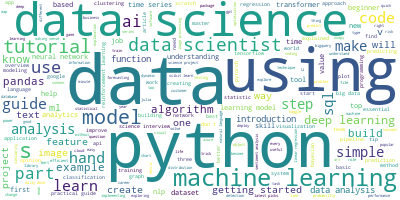

In [343]:
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate & Visualize a word cloud
wordcloud.generate(title_string);
# Visualize the word cloud
wordcloud.to_image()

In [344]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [345]:
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

In [346]:
data = df['paragraphs'].values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

['written', 'emma', 'ding', 'rob', 'wang', 'data', 'science', 'ds', 'relatively', 'new', 'profession', 'compared', 'types', 'roles', 'tech', 'industry', 'software', 'engineering', 'product', 'management', 'initially', 'ds', 'interviews', 'limited', 'coding', 'component', 'including', 'sql', 'applied', 'data']


In [348]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 5), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 3), (13, 2), (14, 1), (15, 8), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 3), (22, 5), (23, 4), (24, 3), (25, 1), (26, 1), (27, 1), (28, 2), (29, 3)]


In [349]:
from pprint import pprint
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.018*"data" + 0.008*"model" + 0.006*"one" + 0.005*"using" + '
  '0.005*"learning" + 0.005*"also" + 0.005*"time" + 0.004*"function" + '
  '0.004*"like" + 0.004*"code"'),
 (1,
  '0.019*"data" + 0.005*"time" + 0.005*"one" + 0.005*"using" + 0.004*"like" + '
  '0.004*"also" + 0.004*"see" + 0.004*"model" + 0.004*"first" + 0.003*"need"'),
 (2,
  '0.011*"data" + 0.008*"model" + 0.005*"one" + 0.005*"time" + 0.005*"would" + '
  '0.004*"using" + 0.004*"like" + 0.004*"also" + 0.004*"used" + '
  '0.004*"function"'),
 (3,
  '0.020*"data" + 0.006*"one" + 0.005*"time" + 0.005*"model" + '
  '0.004*"learning" + 0.004*"function" + 0.004*"also" + 0.004*"would" + '
  '0.004*"first" + 0.003*"see"'),
 (4,
  '0.028*"data" + 0.007*"model" + 0.006*"one" + 0.005*"learning" + '
  '0.005*"also" + 0.004*"using" + 0.004*"science" + 0.004*"code" + '
  '0.004*"first" + 0.004*"used"'),
 (5,
  '0.013*"data" + 0.011*"model" + 0.006*"learning" + 0.006*"using" + '
  '0.005*"like" + 0.004*"one" + 0.004*"code" + 0.0

In [350]:
!pip install pyLDAvis

     |████████████████████████████████| 1.7 MB 9.9 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 99 kB 8.3 MB/s eta 0:00:01
  Using cached sklearn-0.0.tar.gz (1.1 kB)
     |████████████████████████████████| 829 kB 9.6 MB/s eta 0:00:01
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136870 sha256=40271d00e3dd22438af7219b42c0e3c21144ad3a9d14bba8e447128b514c85ee
  Stored in directory: /Users/rachelinsler/Library/Caches/pip/wheels/57/a4/86/d10c6c2e0bf149fbc0afb0aa5a6528ac35b30a133a0270c477
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491059 sha256=3ad2b69a82be7a6b3d63ff7d0b405b05009b773dedacdf70b5d9268376c14f9e
  Stored in directory: /Users/rachelinsler/Library/Caches/pip/wheels/2f/a0/d3/4030d9f80e6b3be787f19fc911b8e7aa462986a40ab1e4bb94
  Created wheel 

In [352]:
import pickle 
import pyLDAvis

/Users/rachelinsler/ENTER/envs/capstone/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#figure out pyldavis without gensim

In [ ]:
df.to_csv(nlp_filename)